# CNN Variants on 1000-Feature Dataset

### Project Overview

This notebook trains and compares **Convolutional Neural Network (CNN)** architectures on a **synthetic dataset** containing 1000 features per sample.  
The aim is to explore how changes in convolutional depth, filter count, kernel size, and pooling strategy affect classification accuracy.

Each sample consists of **1000 numerical features** and a **class label (0–2)**.  
To make the data compatible with CNN layers, features are padded to 1024 (forming a 32×32 grid), then reshaped as single-channel images.


In [21]:
# Import dependencies

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm


In [27]:
def load_preprocess_data(csv_path, test_size=0.2):
    """
    Loads the dataset, normalizes features using Min-Max scaling,
    and reshapes them into 32x32 padded images for CNN input.
    """
    df = pd.read_csv(csv_path)

    # Extract features and labels
    y = df.iloc[:, 0].values.astype(np.int64)
    X = df.iloc[:, 1:].values.astype(np.float32)

    # Min-Max Normalization
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)

    # Pad features from 1000 → 1024 and reshape to (32, 32, 1)
    padding = 24
    X_padded = np.pad(X, ((0, 0), (0, padding)), mode='constant')
    X_reshaped = X_padded.reshape(-1, 1, 32, 32)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=test_size, random_state=42)

    # Convert to PyTorch tensors
    X_train, X_test = torch.tensor(X_train), torch.tensor(X_test)
    y_train, y_test = torch.tensor(y_train), torch.tensor(y_test)

    # Create TensorDatasets
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    return train_dataset, test_dataset


In [35]:
class CNNModel(nn.Module):
    """
    A configurable CNN model for experimentation.
    Automatically infers the flattened feature size for the fully connected layer.
    """
    def __init__(self, num_filters=32, kernel_size=3, num_conv_layers=2, pool_type='max', num_classes=3):
        super(CNNModel, self).__init__()
        layers_list = []
        in_channels = 1

        # Add convolutional layers dynamically
        for i in range(num_conv_layers):
            out_channels = num_filters * (2 ** i)
            layers_list.append(nn.Conv2d(in_channels, out_channels, kernel_size, padding=1))
            layers_list.append(nn.BatchNorm2d(out_channels))
            layers_list.append(nn.ReLU())
            if pool_type == 'max':
                layers_list.append(nn.MaxPool2d(2))
            else:
                layers_list.append(nn.AvgPool2d(2))
            in_channels = out_channels

        self.conv = nn.Sequential(*layers_list)

        # Compute flattened size dynamically using dummy input
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, 32, 32)
            dummy_output = self.conv(dummy_input)
            self.flattened_size = dummy_output.view(1, -1).shape[1]

        self.fc1 = nn.Linear(self.flattened_size, 64)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)  # Flatten dynamically
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [37]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=30, patience=3):
    """
    Trains the CNN with early stopping and returns the training history.
    """
    best_val_loss = float('inf')
    patience_counter = 0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

        train_loss = total_loss / len(train_loader)
        train_acc = correct / total

        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                outputs = model(X_val)
                loss = criterion(outputs, y_val)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == y_val).sum().item()
                val_total += y_val.size(0)

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1:02d}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}, Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}")

        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_weights = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    model.load_state_dict(best_weights)
    return history


In [39]:
# Load Data
train_dataset, test_dataset = load_preprocess_data('synthetic_1000x1000pixels_dataset.csv')

# Train/Validation split
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# Model Variants
variants = [
    {'num_filters':16, 'kernel_size':3, 'num_conv_layers':1, 'pool_type':'max'},
    {'num_filters':16, 'kernel_size':5, 'num_conv_layers':1, 'pool_type':'avg'},
    {'num_filters':32, 'kernel_size':3, 'num_conv_layers':2, 'pool_type':'max'},
    {'num_filters':32, 'kernel_size':5, 'num_conv_layers':2, 'pool_type':'avg'},
    {'num_filters':64, 'kernel_size':3, 'num_conv_layers':3, 'pool_type':'max'},
    {'num_filters':64, 'kernel_size':5, 'num_conv_layers':3, 'pool_type':'avg'}
]

criterion = nn.CrossEntropyLoss()

results = []
for i, cfg in enumerate(variants, 1):
    print(f"\nTraining Variant {i}: {cfg}")
    model = CNNModel(**cfg)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    history = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=30, patience=3)

    # Evaluate on test set
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X_test, y_test in test_loader:
            outputs = model(X_test)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_test).sum().item()
            total += y_test.size(0)
    test_acc = correct / total

    results.append({
        'Model': f'Variant_{i}',
        'Config': cfg,
        'Train Acc': history['train_acc'][-1],
        'Val Acc': history['val_acc'][-1],
        'Test Acc': test_acc,
        'Train Loss': history['train_loss'][-1],
        'Val Loss': history['val_loss'][-1],
        'History': history
    })



Training Variant 1: {'num_filters': 16, 'kernel_size': 3, 'num_conv_layers': 1, 'pool_type': 'max'}
Epoch 01: Train Acc=0.3344, Val Acc=0.3125, Train Loss=1.3625, Val Loss=1.1000
Epoch 02: Train Acc=0.3688, Val Acc=0.3125, Train Loss=1.0965, Val Loss=1.1002
Epoch 03: Train Acc=0.3688, Val Acc=0.3125, Train Loss=1.0963, Val Loss=1.1004
Epoch 04: Train Acc=0.3719, Val Acc=0.3125, Train Loss=1.0959, Val Loss=1.1007
Early stopping triggered.

Training Variant 2: {'num_filters': 16, 'kernel_size': 5, 'num_conv_layers': 1, 'pool_type': 'avg'}
Epoch 01: Train Acc=0.3156, Val Acc=0.3375, Train Loss=1.1883, Val Loss=1.0976
Epoch 02: Train Acc=0.3281, Val Acc=0.3125, Train Loss=1.0990, Val Loss=1.1012
Epoch 03: Train Acc=0.3063, Val Acc=0.3500, Train Loss=1.1099, Val Loss=1.0973
Epoch 04: Train Acc=0.3109, Val Acc=0.3500, Train Loss=1.0984, Val Loss=1.0982
Epoch 05: Train Acc=0.3516, Val Acc=0.3000, Train Loss=1.0936, Val Loss=1.0993
Epoch 06: Train Acc=0.3516, Val Acc=0.3000, Train Loss=1.0976

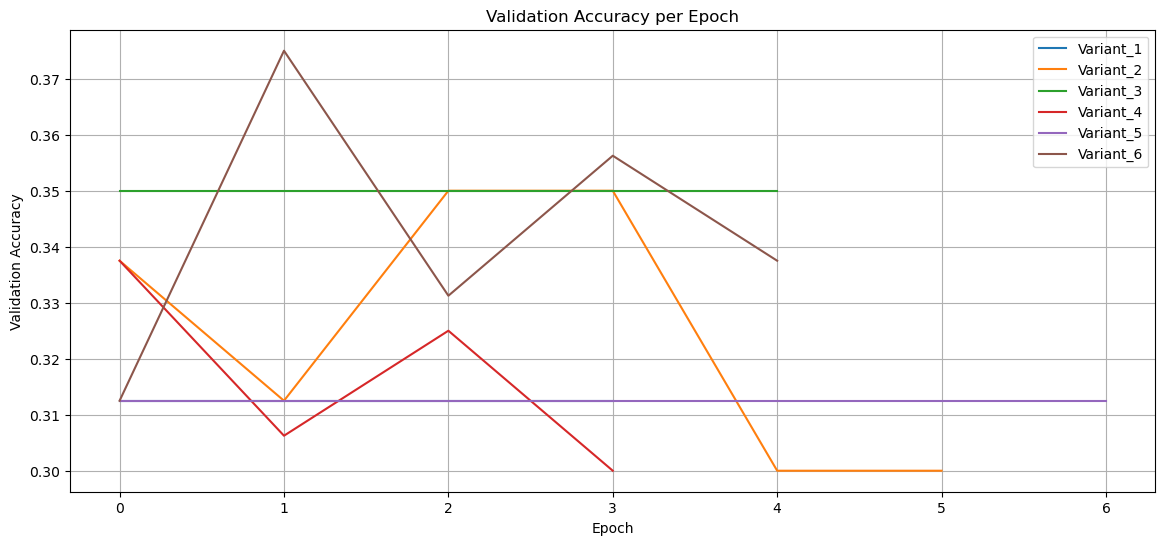

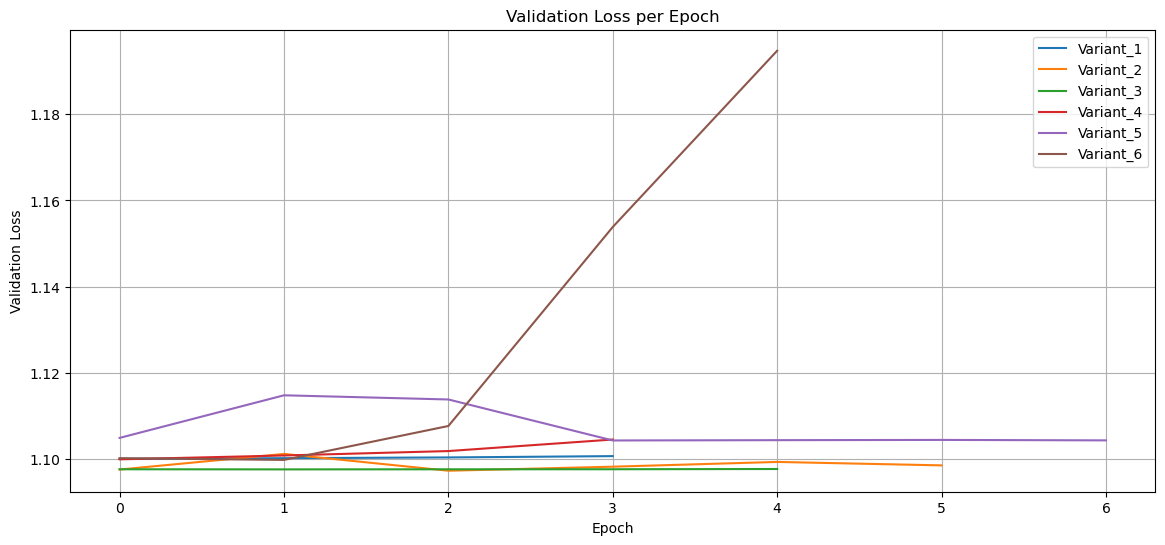

In [41]:
# Validation Accuracy
plt.figure(figsize=(14,6))
for res in results:
    plt.plot(res['History']['val_acc'], label=res['Model'])
plt.title("Validation Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Validation Loss
plt.figure(figsize=(14,6))
for res in results:
    plt.plot(res['History']['val_loss'], label=res['Model'])
plt.title("Validation Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [43]:
summary = []
for res in results:
    cfg = res['Config']
    summary.append({
        'Model': res['Model'],
        'Filters': cfg['num_filters'],
        'Kernel': cfg['kernel_size'],
        'Conv Layers': cfg['num_conv_layers'],
        'Pooling': cfg['pool_type'],
        'Train Acc': round(res['Train Acc'], 4),
        'Val Acc': round(res['Val Acc'], 4),
        'Test Acc': round(res['Test Acc'], 4),
        'Train Loss': round(res['Train Loss'], 4),
        'Val Loss': round(res['Val Loss'], 4)
    })

summary_df = pd.DataFrame(summary)
print("\n=== Summary of All Models ===")
display(summary_df)



=== Summary of All Models ===


,Model,Filters,Kernel,Conv Layers,Pooling,Train Acc,Val Acc,Test Acc,Train Loss,Val Loss
0,Variant_1,16,3,1,max,0.3719,0.3125,0.315,1.0959,1.1007
1,Variant_2,16,5,1,avg,0.3516,0.3000,0.300,1.0976,1.0985
2,Variant_3,32,3,2,max,0.3297,0.3500,0.300,1.1014,1.0977
3,Variant_4,32,5,2,avg,0.4422,0.3000,0.315,1.0517,1.1045
4,Variant_5,64,3,3,max,0.3688,0.3125,0.315,1.0953,1.1043
5,Variant_6,64,5,3,avg,0.6219,0.3375,0.325,0.8638,1.1948


### Key Insights
- Increasing the **number of filters** tends to improve training accuracy but can cause **overfitting**, as seen in Variant_6.  
- Larger **kernel sizes (5×5)** slightly improved feature extraction but did not consistently enhance validation accuracy.  
- **Average pooling** showed comparable performance to **max pooling**, though max pooling was more stable overall.  
- The best performing model in terms of **training accuracy** was Variant_6, while generalization remained moderate across all variants.

### Conclusion
This experiment highlights how CNN architectural variations influence model performance. While deeper and wider models can capture more complex patterns, **overfitting and diminishing validation gains** indicate the need for additional regularization and hyperparameter tuning.